Dimensiones del dataset: (121056, 9)
Período: 2000-01-12 a 2025-02-28

Primeras 5 filas:
        date station  tmin   tmax  trange     rh  wind  pressure  precip
0 2000-01-12   POWER -0.17  11.33   11.50  84.60  1.92     60.30    1.75
1 2000-01-13   POWER  0.62  11.29   10.67  82.36  1.76     60.31    1.19
2 2000-01-14   POWER  1.38   9.57    8.19  85.06  0.95     60.27    1.08
3 2000-01-15   POWER  0.73   8.97    8.24  88.99  1.35     60.17   14.85
4 2000-01-16   POWER -0.68   7.37    8.05  87.86  1.38     60.20   10.52
Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121056 entries, 0 to 121055
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      39715 non-null   datetime64[ns]
 1   station   121056 non-null  object        
 2   tmin      121056 non-null  float64       
 3   tmax      121056 non-null  float64       
 4   trange    121056 non-null  float64       
 5   rh  

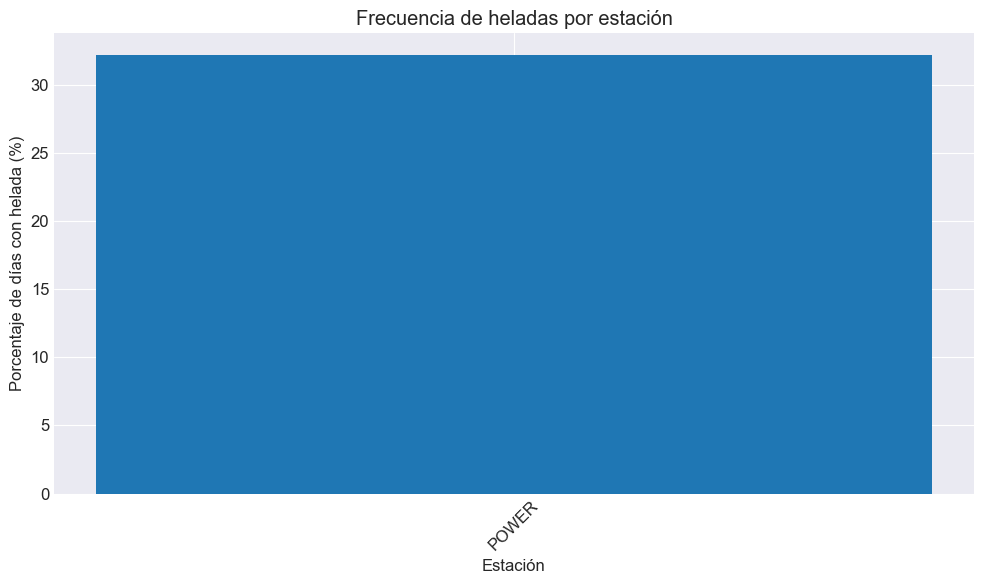

Frecuencia de heladas por estación:
         total_frost_days  frost_percentage
station                                    
POWER               12774          0.321642


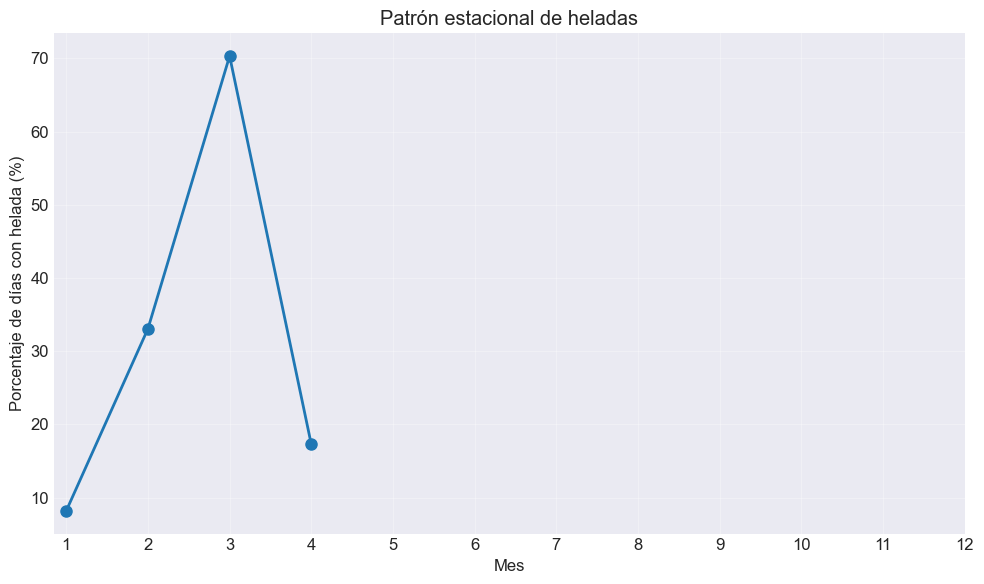

Datasets guardados exitosamente en data/processed/

Información del preprocesamiento guardada en preprocessing_info.json


In [ ]:
# %% [markdown]
# # 01. Preprocesamiento de Datos - Pronóstico de Heladas en el Altiplano

# %% [markdown]
# ## 1. Configuración inicial y carga de librerías

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# %% [markdown]
# ## 2. Carga de datos

# %%
data_path = '../data/raw/master_data.csv'
df = pd.read_csv(data_path)

# Convertir columna date a datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print(f"Dimensiones del dataset: {df.shape}")
print(f"Período: {df['date'].min().date()} a {df['date'].max().date()}")
print(f"\nPrimeras 5 filas:")
print(df.head())

# %% [markdown]
# ## 3. Exploración inicial de datos

# %%
print("Información del dataset:")
print(df.info())

# %%
print("\nEstadísticas descriptivas:")
print(df.describe())

# %%
print("\nEstaciones únicas:")
print(df['station'].value_counts())

# %%
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percentage.values
})

print("\nValores faltantes por columna:")
print(missing_df[missing_df['Missing_Count'] > 0])

# %% [markdown]
# ## 4. Preprocesamiento de datos

# %%
# Eliminar filas sin fecha antes de interpolar
df = df.dropna(subset=['date'])

# Ordenar por estación y fecha
df = df.sort_values(['station', 'date'])

# Calcular temperatura media (tmean)
df['tmean'] = (df['tmin'] + df['tmax']) / 2

# Crear columna de helada (temperatura <= 0°C)
df['is_frost'] = (df['tmin'] <= 0).astype(int)

print(f"Porcentaje de días con helada: {df['is_frost'].mean()*100:.2f}%")

# %%
# Manejo de valores faltantes: Interpolación temporal por estación y por variable
df = df.set_index('date')
for station in df['station'].unique():
    mask = df['station'] == station
    for col in ['tmin', 'tmax', 'tmean', 'rh', 'wind', 'pressure', 'precip']:
        if col in df.columns:
            df.loc[mask, col] = df.loc[mask, col].interpolate(method='time')
df = df.reset_index()

print("Valores faltantes después de interpolación:")
print(df.isnull().sum())

# %% [markdown]
# ## 5. Ingeniería de características

# %%
# Características temporales
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week

# Características estacionales (hemisferio sur)
def get_season(month):
    if month in [12, 1, 2]:
        return 'summer'
    elif month in [3, 4, 5]:
        return 'autumn'
    elif month in [6, 7, 8]:
        return 'winter'
    else:
        return 'spring'

df['season'] = df['month'].apply(get_season)

# Codificación one-hot de la estación del año
season_dummies = pd.get_dummies(df['season'], prefix='season')
df = pd.concat([df, season_dummies], axis=1)

# %%
# Características derivadas

# Rango térmico diario (ya tienes trange, pero lo recalculamos para estar seguros)
df['temp_range'] = df['tmax'] - df['tmin']

# Desviación de la temperatura media
df['temp_deviation'] = df['tmean'] - df.groupby(['station', 'month'])['tmean'].transform('mean')

# %%
# Características de rezagos (lags)
lag_features = ['tmin', 'tmax', 'tmean', 'rh', 'pressure']
lag_days = [1, 2, 3, 7]

for feature in lag_features:
    for lag in lag_days:
        df[f'{feature}_lag{lag}'] = df.groupby('station')[feature].shift(lag)

# %%
# Características de ventana móvil
window_sizes = [3, 7, 14]

for feature in ['tmin', 'tmean']:
    for window in window_sizes:
        df[f'{feature}_ma{window}'] = df.groupby('station')[feature].transform(
            lambda x: x.rolling(window, center=True).mean()
        )
        df[f'{feature}_std{window}'] = df.groupby('station')[feature].transform(
            lambda x: x.rolling(window, center=True).std()
        )

# %% [markdown]
# ## 6. División temporal de datos

# %%
train_end = '2021-12-31'
val_end = '2023-12-31'

train_mask = df['date'] <= train_end
val_mask = (df['date'] > train_end) & (df['date'] <= val_end)
test_mask = df['date'] > val_end

train_data = df[train_mask].copy()
val_data = df[val_mask].copy()
test_data = df[test_mask].copy()

print(f"Dataset de entrenamiento: {len(train_data)} registros ({train_data['date'].min()} a {train_data['date'].max()})")
print(f"Dataset de validación: {len(val_data)} registros ({val_data['date'].min()} a {val_data['date'].max()})")
print(f"Dataset de prueba: {len(test_data)} registros ({test_data['date'].min()} a {test_data['date'].max()})")

# %%
train_data = train_data.dropna()
val_data = val_data.dropna()
test_data = test_data.dropna()

print(f"\nDespués de eliminar NaN:")
print(f"Train: {len(train_data)} registros")
print(f"Val: {len(val_data)} registros")
print(f"Test: {len(test_data)} registros")

# %% [markdown]
# ## 7. Análisis de distribución de heladas

# %%
frost_by_station = df.groupby('station')['is_frost'].agg(['sum', 'mean'])
frost_by_station.columns = ['total_frost_days', 'frost_percentage']
frost_by_station = frost_by_station.sort_values('frost_percentage', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(frost_by_station.index, frost_by_station['frost_percentage'] * 100)
plt.xlabel('Estación')
plt.ylabel('Porcentaje de días con helada (%)')
plt.title('Frecuencia de heladas por estación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../results/figures/frost_frequency_by_station.png', dpi=300)
plt.show()

print("Frecuencia de heladas por estación:")
print(frost_by_station)

# %%
monthly_frost = df.groupby('month')['is_frost'].mean() * 100

plt.figure(figsize=(10, 6))
plt.plot(monthly_frost.index, monthly_frost.values, 'o-', linewidth=2, markersize=8)
plt.xlabel('Mes')
plt.ylabel('Porcentaje de días con helada (%)')
plt.title('Patrón estacional de heladas')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/monthly_frost_pattern.png', dpi=300)
plt.show()

# %% [markdown]
# ## 8. Guardar datasets procesados

# %%
columns_to_save = [col for col in df.columns if col != 'season']  # season ya está codificada

train_data[columns_to_save].to_csv('../data/processed/train_data.csv', index=False)
val_data[columns_to_save].to_csv('../data/processed/val_data.csv', index=False)
test_data[columns_to_save].to_csv('../data/processed/test_data.csv', index=False)

print("Datasets guardados exitosamente en data/processed/")

# %%
preprocessing_info = {
    'total_records': len(df),
    'train_records': len(train_data),
    'val_records': len(val_data),
    'test_records': len(test_data),
    'features_created': list(df.columns),
    'train_period': f"{train_data['date'].min()} to {train_data['date'].max()}",
    'val_period': f"{val_data['date'].min()} to {val_data['date'].max()}",
    'test_period': f"{test_data['date'].min()} to {test_data['date'].max()}",
    'frost_percentage': df['is_frost'].mean() * 100,
    'stations': list(df['station'].unique())
}

import json
with open('../data/processed/preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=4, default=str)

print("\nInformación del preprocesamiento guardada en preprocessing_info.json")
